In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import stylecloud
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

##### Read_csv files

In [82]:
# train data
tweet_data=pd.read_csv('train.csv')
#Read test data
test_data=pd.read_csv('test.csv')

In [83]:
# check null values
tweet_data.isnull().sum()

tweet_id     0
tweet        1
sentiment    0
dtype: int64

In [84]:
# dropping null values
tweet_data=tweet_data.drop('tweet_id',axis=1)
tweet_data.dropna(axis=0,inplace=True)

In [85]:
# print total number of tweets
print('Number of tweets :',tweet_data['tweet'].shape[0])

Number of tweets : 7273


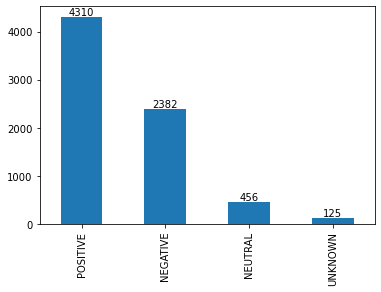

In [86]:
# bar plot of tweets
no_of_tweets=tweet_data['sentiment'].value_counts()
no_of_tweets.plot(kind='bar').set_xticklabels(['POSITIVE','NEGATIVE','NEUTRAL','UNKNOWN'])
for i,n in enumerate(no_of_tweets,0):
    plt.text(i,n,n,horizontalalignment='center',verticalalignment='bottom')

In [87]:
# dictionary to covert full forms
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works fo\r me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [88]:
# dictionary for negations
negation_dic={"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"pls":"please",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
"ya'll":"you all",
"w/out":"workout"
}

In [89]:
def clean_tweet(tweet):
    tweet=re.sub(r'((w{3,}\.|https?|bit\.ly|[^\s]+\.(co|com)).[^\s]*|{link})',' ',tweet)
    tweet=re.sub(r'([a-zA-Z])\1{2,}',r'\1',tweet)
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' happy ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' happy ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' happy ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' happy ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' sad ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' sad ', tweet)
    
    tweet=re.sub(r'[a-zA-z0-9_.+-]*[\@]+[a-zA-Z0-9_.+-]+',' ',tweet)
    #tweet = re.sub(r'.\#+?[a-zA-Z0-9_.+-]+',' ',str(tweet),flags=re.I)
    tweet=re.sub(r'(^RT|[\s]+(RT|rt)[\s]+)',r' ',tweet)
    tweet=re.sub(r'\$\w*',' ',tweet)
    tweet=re.sub(r'&\w*',' ',tweet)
    
    tweet=tweet.encode('utf-8')
    tweet=re.sub(rb'[^\x00-\x7f]',rb' ',tweet)
    return tweet.decode('utf-8')

In [90]:
clean_tweets=[]
for tweet in tweet_data['tweet']:
    clean_tweets.append({'tweet':clean_tweet(tweet)})
        
clean_data=pd.DataFrame(clean_tweets)

In [91]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

In [92]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [93]:
def treatment_tweet(tweet):
    tweet= tweet.lower()
    p =re.compile(r'\b(' + '|'.join(short_word_dict.keys()) + r')\b')
    tweet = p.sub(lambda x: short_word_dict[x.group()],tweet)
    q =re.compile(r'\b(' + '|'.join(negation_dic.keys()) + r')\b')
    tweet = q.sub(lambda x: negation_dic[x.group()],tweet)
    tweet = re.sub(r'[^a-zA-Z]',' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', ' ', tweet)
    tweet = re.sub(r'[\s]+', ' ', tweet ) #Remove additional white spaces
    tweet = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenizer.tokenize(tweet)])
    tweet = ' '.join([word for word in tokenizer.tokenize(tweet) if word not in stop_words])
    tweet = tweet.strip(' ')
    return tweet

In [94]:
stop_words = list(stopwords.words('english')) 
list_processed_tweet=[]
with open("preprocess.txt",'w') as f:
    for tweet in clean_data['tweet']:
        list_processed_tweet.append({'tweet':treatment_tweet(tweet)})
        f.writelines(treatment_tweet(tweet) +'\n')
    f.close()
preprocessed_tweet=pd.DataFrame(list_processed_tweet)
preprocessed_tweet.drop(index=[6799],axis=0,inplace=True)
tweet_data['sentiment'].drop(index=[6800],axis=0,inplace=True)
preprocessed_tweet.to_csv('preprocess.csv',index=False)
tweet_data['sentiment'].to_frame().to_csv('sentiment.csv',index=False)

In [694]:

stylecloud.gen_stylecloud(file_path="preprocess.txt",
                          icon_name='fab fa-twitter',
                          size=1080,
                          palette="cartocolors.diverging.TealRose_7",
                          background_color='black',
                          custom_stopwords=stop_words,gradient='horizontal',
                          max_words=200,random_state=41,collocations=False)

c:\users\dazzabhi\appdata\local\programs\python\python37\lib\site-packages\stylecloud\stylecloud.py:135: MatplotlibDeprecationWarning: 
The makeMappingArray function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. This is not considered public API any longer.
  gradient = np.array(makeMappingArray(size, palette_func.mpl_colormap))


In [95]:
preprocessed_data=pd.read_csv('preprocess.csv')
tweet_data_1=pd.read_csv('sentiment.csv')

In [96]:
X=preprocessed_data['tweet']
y=tweet_data_1['sentiment']
print(X.shape,y.shape)

(7272,) (7272,)


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
parameters = {
    'tfidfvectorizer__lowercase': [False],
    'tfidfvectorizer__max_df': (0.5, 0.75, 1.0),
    'tfidfvectorizer__ngram_range': ((1, 1), (1, 2),(1,3), (2, 2),(2,3)),
    'clf__C': (0.1,1, 10, 100),
    #'clf__penalty': ('l1', 'l2'),
    'clf__gamma': (1,0.1,0.01,0.001),
    'clf__kernel': ('rbf', 'poly', 'linear','sigmoid')
}

In [9]:
model_pipeline = Pipeline([
    ('tfidfvectorizer', TfidfVectorizer()),
     #('svd',TruncatedSVD()),
    #('model',MultinomialNB()),
    #('model_1',LogisticRegression())
    ('clf',SVC())
    
])

In [10]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)


In [127]:
grid_search = GridSearchCV(model_pipeline, parameters, n_jobs=-1,cv=cv, verbose=1,scoring='f1_weighted')
print("Performing grid search...")
print("pipeline:", [name for name, _ in model_pipeline.steps])
grid_search.fit(X_train,y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidfvectorizer', 'clf']
Fitting 15 folds for each of 960 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 63.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 84.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 113.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 137.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 173.4min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 212.2min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 255.6min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 297.2min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 368.6min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 439.7min
[Parallel(n_jobs=-1)]: Done 11242 task

Best score: 0.652
Best parameters set:
	clf__C: 100
	clf__gamma: 0.01
	clf__kernel: 'rbf'
	tfidfvectorizer__lowercase: False
	tfidfvectorizer__max_df: 1.0
	tfidfvectorizer__ngram_range: (1, 3)


In [98]:
test_data=test_data.drop('tweet_id',axis=1)
test_data.dropna(axis=0,inplace=True)

In [99]:
clean_tweets_1=[]
for tweet in test_data['tweet']:
    clean_tweets_1.append({'tweet':clean_tweet(tweet)})
        
clean_data_1=pd.DataFrame(clean_tweets_1)

In [100]:
list_processed_tweet_1=[]
for tweet in clean_data_1['tweet']:
    list_processed_tweet_1.append({'tweet':treatment_tweet(tweet)})

preprocessed_tweet_1=pd.DataFrame(list_processed_tweet_1)

In [101]:
vectorizer_1= TfidfVectorizer(lowercase=False,ngram_range=(1,2),max_df=1.0)

vectorizer_1.fit(preprocessed_data['tweet'])
vect_1=vectorizer_1.transform(preprocessed_tweet_1['tweet'])
vect_2=vectorizer_1.transform(preprocessed_data['tweet'])


In [102]:
feature_names = vectorizer_1.get_feature_names()
print(np.asarray(feature_names).shape)

(36468,)


In [41]:
#sm=SMOTE()
#X_resampled_1,y_resampled_1=sm.fit_sample(vect_2,y)

In [109]:
svc=SVC(C=10,gamma=0.1,kernel='rbf')
#logreg_1=LogisticRegression(C=1,penalty='l2')
svc.fit(vect_2,y)
#print("Best score: %0.3f" % svc.best_score_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [110]:
y_pred=svc.predict(vect_1)

In [111]:
test_df=pd.read_csv('test.csv')


In [112]:
to_submit = pd.DataFrame({'tweet_id': test_df['tweet_id'] ,'sentiment': y_pred} )

In [113]:
to_submit.to_csv('first_submission21.csv', index=False)

In [114]:
to_submit.sentiment.value_counts()

1    1241
2     519
0      54
3       5
Name: sentiment, dtype: int64